<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Intro to Data Science Ethics: COMPAS Recidivism Case Study

_Author:_ Dan Wilhelm

---

### Learning Objectives

- Understand different ways of interpreting "fairness".
- Critically consider biases that may exist in models.
- Create and assess model "fairness".
- Understand some ways people assess fairness in models.

## Introduction

Suppose you are given the following text about a criminal defendant:

> The defendant is a [SEX] aged [AGE]. They have been charged with: [CRIME CHARGE]. This crime is classified as a [CRIMINAL DEGREE]. They have been convicted of [NON-JUVENILE PRIOR COUNT] prior crimes. They have [JUVENILE- FELONY COUNT] juvenile felony charges and [JUVENILE-MISDEMEANOR COUNT] juvenile misdemeanor charges on their record.

You must then respond "yes" or "no" to:
    
> "Do you think this person will commit another crime within 2 years?”

---

### Questions

> 1. Given the above, brainstorm three ways to determine whether someone is "fair" in their responses.

In [ ]:
A: 

> 2. Many characteristics are not mentioned in the prompt -- race, religion, disability, etc. Could the prompt be modified to cause higher "yes" rates for some of these groups, even though they are not specifically mentioned? Would this be considered "unfair"?

In [ ]:
A: 

> 3. If we find that there are higher "yes" rates for some groups, would it always be "unfair"? What might some criteria be for deciding this?

In [ ]:
A: 

---

### Background

COMPAS -- Correctional Offender Management Profiling for Alternative Sanctions -- is a proprietary predictive model created by Northpointe. 

COMPAS uses 173 features to estimate a "recidivism score" from 1 to 10 (low risk to high risk).

+ "Recidivism" is interpreted as "a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored." [Source](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

+ The features include an individual's criminal history and associates, drug involvement, and indications of juvenile delinquency. [Source](https://en.wikipedia.org/wiki/COMPAS_(software))

+ This model is often used by the U.S. court system. [Source](https://en.wikipedia.org/wiki/COMPAS_(software))

---

## Why Is COMPAS "Fair"?

COMPAS's risk score directly translates into a risk of recidivism - regardless of race. Here is evidence:

![Washington Post](assets/compas/recidivism_by_race_wapo.png)
[Source: Washington Post](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)

---

### Questions

> 1. Suppose that one group has a higher rate of recidivism than the other. What practical effects might this necessarily have on predictions, given the above?

In [ ]:
A: 

> 2. Suppose you only look at those who do not reoffend. Will their estimated COMPAS scores be higher, lower, or the same if they are a member of the "higher recidivism rate" group?

In [ ]:
A: 

---

## Why Isn't COMPAS "Fair"?

ProPublica found that - among defendants who did not reoffend - black defendants were more than twice as likely as white defendants to be classified as medium or high risk (42 percent vs. 22 percent). So, through no fault of their own, black defendants were subjected to harsher treatment by the courts. ProPublica claimed that no system can be fair if it discriminates against people this way. [Source](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/?noredirect=on&utm_term=.c7d837ce9d24)

![ProPublica](assets/compas/distribution_recid_wapo.png)
[Source: ProPublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

In fact, here we see how many defendants were assigned each risk score, grouped by race:

![ProPublica](assets/compas/decile_race_propublica.png)
[Source: ProPublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

---

## Which "fairness" metric is correct?

Each gives a compelling case, and ideally we would be able to achieve both.

However, as the Washington Post points out below, it is mathematically impossible to satisfy both fairness criteria simultaneously:

"
1. Within each risk category, the proportion of defendants who reoffend is approximately the same regardless of race; this is Northpointe’s definition of fairness.

2. The overall recidivism rate for black defendants is higher than for white defendants (52 percent vs. 39 percent).

3. Black defendants are more likely to be classified as medium or high risk (58 percent vs. 33 percent). While Northpointe’s algorithm does not use race directly, many attributes that predict reoffending nonetheless vary by race. For example, black defendants are more likely to have prior arrests, and since prior arrests predict reoffending, the algorithm flags more black defendants as high risk even though it does not use race in the classification.

4. Black defendants who don’t reoffend are predicted to be riskier than white defendants who don’t reoffend; this is ProPublica’s criticism of the algorithm.

" - [Washington Post](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/?noredirect=on&utm_term=.c7d837ce9d24)

---

## Question

> The final two points are mathematically guaranteed given the first two! Can you write an explanation why?

In [ ]:
A: 

---

Let's examine additional stats ourselves using the COMPAS dataset (adapted from the [Aequitas COMPAS demo]( https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)).

In [4]:
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
df = pd.read_csv("data/compas_for_aequitas.csv")
df.head()

entity_id  score  label_value              race   sex          age_cat
0          1    0.0            0             Other  Male  Greater than 45
1          3    0.0            1  African-American  Male          25 - 45
2          4    0.0            1  African-American  Male     Less than 25
3          5    1.0            0  African-American  Male     Less than 25
4          6    0.0            0             Other  Male          25 - 45

In [6]:
df.shape

(7214, 6)

## Pre-Aequitas: Exploring the COMPAS Dataset

__Risk assessment by race__

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk.

This categorization is based on ProPublica's interpretation of Northpointe's practioner guide:

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range garner more 
    interest from supervision agencies than low scores, as a low score would suggest there is little risk of 
    general recidivism,” so we considered scores any higher than “low” to indicate a risk of recidivism."

In the bar charts below, we see a large difference in how these scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk (score = 1). We also see that while the majority of people in age categories over 25 are predicted as low risk (score = 0), the majority of people below 25 are predicted as high and medium risk (score = 1).

In [9]:
aq_palette = sns.diverging_palette(225, 35, n=2)

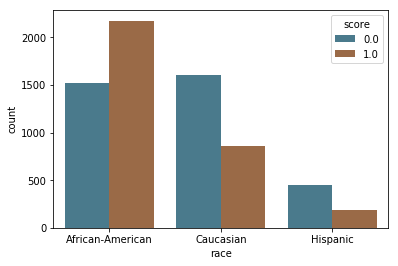

In [10]:
by_race = sns.countplot(x="race", 
                        hue="score", 
                        data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], 
                        palette=aq_palette)

From this, we conclude that a much larger fraction of African-American defendants are predicted to be "medium or high risk" than Caucasian or Hispanic defendants.

---

## Questions

> Using the above as an example:
1. Make a `countplot` that shows score counts by sex. Describe the results in words.

> 2. Make a `countplot` that shows score counts by age category. Describe the results in words.

---

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"




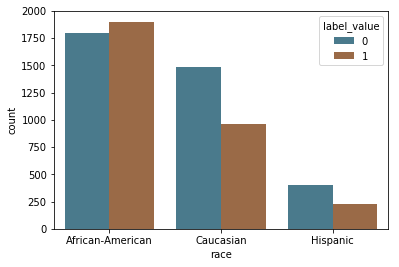

In [8]:
label_by_race = sns.countplot(x="race", 
                              hue="label_value", 
                              data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], 
                              palette=aq_palette)

From this, we conclude that a larger fraction of African-American defendants recidivate than Caucasian and Hispanic defendants.

---

## Questions

> Using the above as an example:
1. Make a `countplot` that shows label_value counts by sex. Describe the results in words.

> 2. Make a `countplot` that shows label_value counts by age category. Describe the results in words.

## A Third Way of Measuring Fairness

What if we have humans replicate what COMPAS is doing? It turns out that humans score very similarly to COMPAS *and* have nearly identical biases:

![Science Advances](assets/compas/human_results_science.jpg)
[Source](http://advances.sciencemag.org/content/4/1/eaao5580.full)

## Question

> Should algorithms be subjected to higher standards than humans on the same task?

In [ ]:
A: 

> Given the three fairness methods above as a whole, what might be your ultimate conclusion about whether COMPAS is "fair"? Is there anything we could do to further improve it?

In [ ]:
A: 

---

## Inner Workings of COMPAS

Let's examine how the COMPAS model might work. In a "Science Advances" paper, authors attempted modeling defendant data using vastly fewer than COMPAS's 137 features. (In fact, they used the same 7214 defendants in the dataset in `df`!) For the two-feature model, the authors used age and total number of previous convictions. Here are their results compared to COMPAS:

![Science Advances](assets/compas/algorithms_science.png)
[Source](http://advances.sciencemag.org/content/4/1/eaao5580.full)


---

## Questions

> 1. Generally, logistic regression performs worse than NL-SVM (Non-Linear Support Vector Machine). However, here it performs better! What does that indicate?

In [ ]:
A: 

> 2. Explain why there are ranges of accuracy values rather than a single accuracy value.

In [ ]:
A: 

> 3. Is the seven-feature LR model better or worse than the two-feature LR model? Why?

In [ ]:
A: 

> 4. If you had to guess, what type of model might COMPAS be? Why?

In [ ]:
A: 

## Challenge

> Make a logistic regression using `sex` and `age_cat`. Keep in mind that `score` is the COMPAS score (0=low, 1=med or high), and `label_value` is 1 if the defendant was re-arrested.

In [10]:
df.head()

entity_id  score  label_value              race   sex          age_cat
0          1    0.0            0             Other  Male  Greater than 45
1          3    0.0            1  African-American  Male          25 - 45
2          4    0.0            1  African-American  Male     Less than 25
3          5    1.0            0  African-American  Male     Less than 25
4          6    0.0            0             Other  Male          25 - 45

> How close is your model to COMPAS? To the researchers' logistic regressions?

---

## Something else to keep in mind

This same concept happens all the time in data science.

To increase one metric, we often must sacrifice another.

- "No free lunch theorem": Bias versus Variance.
- "ROC Curve": True Positive Rate (TPR) vs False Positive Rate (FPR).

![Wikipedia](assets/compas/roc_curve_wikipedia.png)
[Source](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

- As the threshold increases, the FPR necessarily increases and the TPR necessarily decreases.
- As the threshold decreases, the FPR necessarily decreases and the TPR necessarily increases.



---

## An Early Tool for Fairness Auditing: Aequitas

Portions of the following are adopted from the Aequitas COMPAS demo: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb

### What is Aequitas?

![Aequitas Flow](assets/aequitas_flow.png)

> "[Aequitas is] an open source bias audit toolkit for machine learning developers, analysts, and  policymakers to audit machine learning models for discrimination and bias, and make informed and equitable decisions around developing and deploying predictive risk-assessment tools." - [Source](https://dsapp.uchicago.edu/projects/aequitas/)


Aequitas allows you to use multiple metrics for "fairness":

> "Different bias and fairness criteria need to be used for different types of interventions. Aequitas allows audits to be done across multiple metrics." - [Source](https://dsapp.uchicago.edu/projects/aequitas/)

Some examples of "fairness" metrics:

- **Equal Parity**: Each group represented equally.

- **Proportional Parity**: Each group represented proportional to their representation in the overall population.

- **False Positive Parity**: Each group has equal false positive rates.

- **False Negative Parity**: Each group has equal false negative rates.

---

## Questions

> 1. In the U.S. House, we want to ensure each group of voters is equally represented based on their proportion of the population. Which metric should we use?

> 2. Suppose we are predicting whether a defendant is guilty. We want to minimize the times we predict a defendant is guilt but is actually not guilty. However, when these mistakes occur, we want them to occur at an equal rate per group. Which metric should we use?

> 3. In the U.S. Senate, we want to ensure that representatives of each state have the same amount of voting power, regardless of its population. Which metric should we use?

> 4. We are predicting whether it is safe for a rocket ship to launch. When we are wrong, we prefer to predict it should not be launched. Further, for different rocket ship manufacturers we want this to occur at the same rate. Which metric should we use?

In [ ]:
A: 

---

Let's look at some ways that the Aequitas library can help assess model fairness.

### Visualizing a single absolute group metric across all population groups
The chart below displays group metric False Negative Rate (fnr) calculated across each attribute, colored based on number of samples in the attribute group. 

We can see from the longer bars that across 'age_cat', 'sex', and 'race' attributes, the groups COMPAS incorrectly predicts as 'low' or 'medium' risk most often are 25-45, Male, and African American. From the darker coloring, we can also tell that these are the three largest populations in the data set.

---
# Do not run any code below this point!!!!
If you accidentally run a cell, see the original sheet here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb

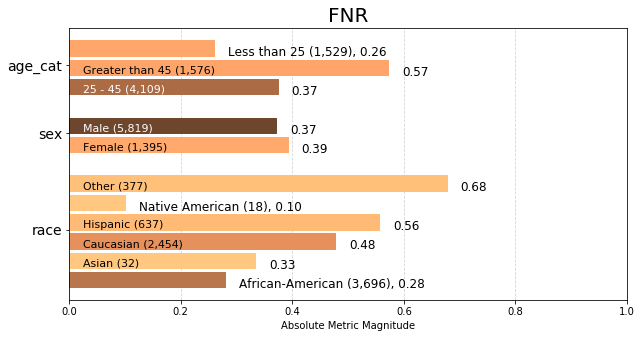

In [16]:
# fnr = aqp.plot_group_metric(xtab, 'fnr')

### View group metrics for only groups over a certain size threshold
Extremely small group sizes increase standard error of estimates, and could be factors in prediction error such as false negatives. Use the `min_group` parameter to vizualize only those sample population groups above a user-specified percentage of the total sample size. When we remove groups below 5% of the sample size, we are left with only two of the six 'race' groups, as there are much smaller groups in that attribute category than in 'sex' or 'age_cat' (age cateogry). 

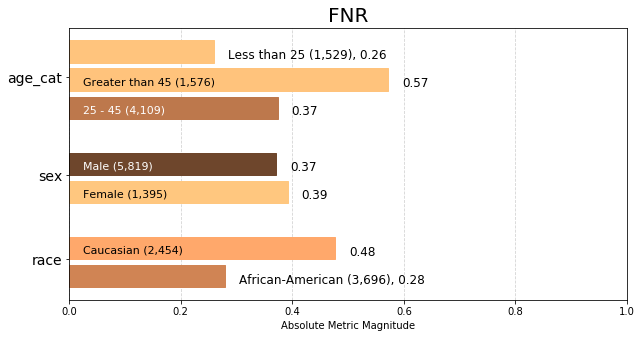

In [17]:
# fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)

### Visualizing multiple user-specified absolute group metrics across all population groups

The charts below display the all calculated group metrics across each attribute, colored based on absolute metric magnitude.

We can see that the largest 'race' group, African Americans, are predicted positive more often than any other race group (predicted positive rate `PPR` of 0.66), and are more likely to be incorrectly classified as 'high' risk (false positive rate `FPR` of 0.45) than incorrectly classified as 'low' or 'medium' risk (false negative rate `FNR` of 0.28). Note that Native Americans are predicted positive at a higher _prevalence_ `PPREV`in relation to their group size than all other 'race groups' (predicted prevalence of 0.67). 

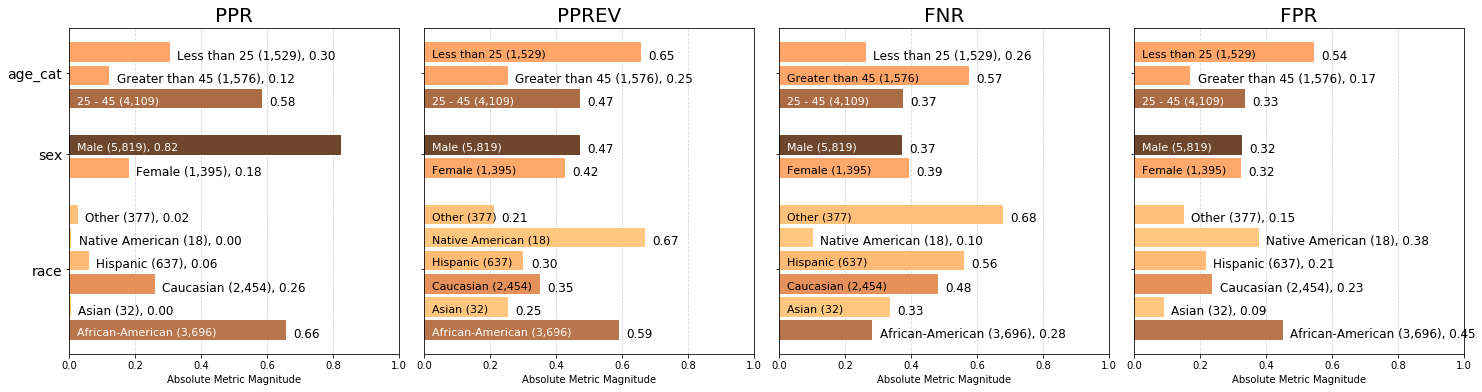

In [18]:
# p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

### Visualizing default absolute group metrics across all population groups
#### Default absolute group metrics
When visualizing more than one absolute group metric, you can specify a list of metrics, specify `'all'` metrics, or use the Aequitas default metrics by not supplying an argument:
- Predicted Positive Group Rate Disparity (pprev), 
- Predicted Positive Rate Disparity (ppr),  
- False Discovery Rate (fdr), 
- False Omission Rate (for)
- False Positive Rate (fpr)
- False Negative Rate (fnr)

The charts below display the default group metrics calculated across each attribute, colored based on number of samples in the attribute group. 

Note that the 45+ age category is almost twice as likely to be incorrectly included in an intervention group (false discovery rate `FDR` of 0.46) than incorrectly excluded from intervention (false omission rate `FOR` 0.24). We can also see that the model is equally likely to predict a woman as 'high' risk as it is for a man (false positive rate `FPR` of 0.32 for both Male and Female).

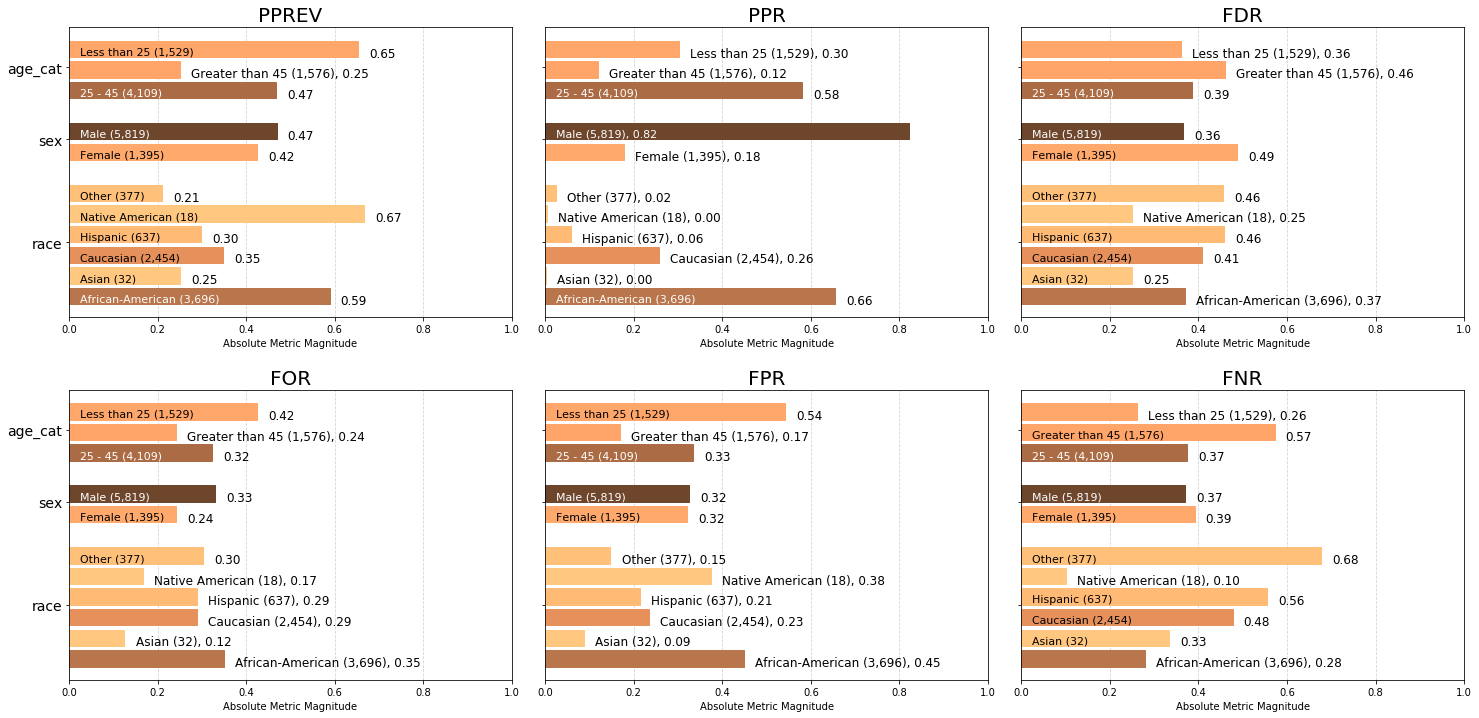

In [19]:
# a = aqp.plot_group_metric_all(xtab, ncols=3)

[Back to Top](#top_cell)
<a id='disparities'></a>
## What levels of disparity exist between population groups?
### Aequitas Bias() Class
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner. 

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below. 

### Visualizing disparities between groups in a single user-specified attribute for a single user-specified disparity metric

The treemap below displays precision disparity values calculated using a predefined group, in this case the 'Caucasian' group within the race attribute, sized based on the group size and colored based on disparity magnitude. We can see from asterisks that the disparities between the 'Caucasian' reference population group and both the 'African-American' and 'Other' race population groups are statistically significant at the 5% level.

**Note**: Groups are visualized at no less than 0.1 times the size of the reference group, and no more than 10 times the size of the reference group.

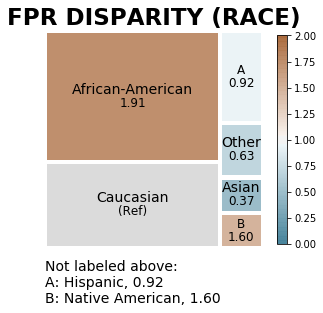

In [32]:
# aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)

[Back to Top](#top_cell)
<a id='fairness'></a>
## How do I assess model fairness?
### Aequitas Fairness() Class
Finally, the Aequitas `Fairness()` class provides three functions that provide a high level summary of fairness. This class builds on the dataframe returned from one of the three `Bias()` class `get_dispariy` methods. 

Using FPR disparity as an example and the default fairness threshold, we have:

$$ 0.8 < Disparity_{FNR} =  \frac{FPR_{group}}{FPR_{base group}} < 1.25 $$ 

We can assess fairness at various levels of detail:

### Visualizing parity of a single absolute group metric across all population groups

The chart below displays absolute group metric Predicted Positive Rate Disparity (ppr) across each attribute, colored based on fairness determination for that attribute group (green = 'True' and red = 'False'). 

We can see from the green color that only the 25-45 age group, Male category, and Caucasian groups have been determined to be fair. Sound familiar? They should! These are the groups selected as reference groups, so this model is not fair in terms of Statistical Parity for any of the other groups.

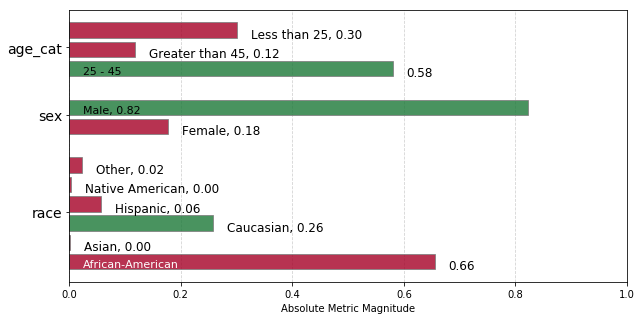

In [43]:
# z = aqp.plot_fairness_group(fdf, group_metric='ppr')

## The Aequitas Effect

By breaking down the COMPAS predictions using a variety of bias and disparity metrics calculated using different reference groups, we are able to surface the specific metrics for which the model is imposing bias on given attribute groups, and have a clearer lens when evaluating models and making recommendations for intervention. 

Researchers utilizing Aequitas will be able to make similar evaluations on their own data sets, and as they continue to use the tool, begin to identify patterns in where biases exist and which models appear to produce less bias that aid in reducing bias in future algorithm-based decision making.